In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import & Merge Data**

In [ ]:
import pandas as pd

file_path = '/content/drive/My Drive/Dataset/New Data/'
reservoir = pd.read_csv(file_path + 'Reservoir.csv')
rainfall = pd.read_csv(file_path + '/Rainfall.csv')
GW = pd.read_csv(file_path + '/GW.csv')

In [ ]:
reservoir.head()

,Date,Basin,Level
0,2023-01-01,Cauvery Basin,618.709333
1,2023-01-02,Cauvery Basin,618.626000
2,2023-01-03,Cauvery Basin,565.101800
3,2023-01-04,Cauvery Basin,618.621500
4,2023-01-05,Cauvery Basin,565.077800


In [ ]:
rainfall.head()

,Basin,Date,Avg_rainfall
0,Cauvery Basin,2023-01-01,NaN
1,Cauvery Basin,2023-01-02,0.008804
2,Cauvery Basin,2023-01-03,0.012438
3,Cauvery Basin,2023-01-04,NaN
4,Cauvery Basin,2023-01-05,0.000033


In [ ]:
GW.head()

,Basin,Date,GW Level(mbgl)
0,Cauvery Basin,2023-01-01,6.579664
1,Cauvery Basin,2023-01-02,6.636889
2,Cauvery Basin,2023-01-03,6.540578
3,Cauvery Basin,2023-01-04,6.729337
4,Cauvery Basin,2023-01-05,6.833225


In [ ]:
df_temp = pd.merge(reservoir, rainfall, on=["Basin", "Date"], how="outer")
df = pd.merge(df_temp, GW, on=["Basin", "Date"], how="outer")

df.head()

,Date,Basin,Level,Avg_rainfall,GW Level(mbgl)
0,2023-01-01,Cauvery Basin,618.709333,NaN,6.579664
1,2023-01-02,Cauvery Basin,618.626000,0.008804,6.636889
2,2023-01-03,Cauvery Basin,565.101800,0.012438,6.540578
3,2023-01-04,Cauvery Basin,618.621500,NaN,6.729337
4,2023-01-05,Cauvery Basin,565.077800,0.000033,6.833225


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            357 non-null    object 
 1   Basin           357 non-null    object 
 2   Level           320 non-null    float64
 3   Avg_rainfall    313 non-null    float64
 4   GW Level(mbgl)  357 non-null    float64
dtypes: float64(3), object(2)
memory usage: 14.1+ KB


In [ ]:
df.tail()

,Date,Basin,Level,Avg_rainfall,GW Level(mbgl)
352,2023-12-19,Cauvery Basin,NaN,NaN,10.176268
353,2023-12-20,Cauvery Basin,NaN,NaN,10.202585
354,2023-12-21,Cauvery Basin,NaN,NaN,10.177615
355,2023-12-22,Cauvery Basin,NaN,NaN,10.058304
356,2023-12-23,Cauvery Basin,NaN,NaN,9.318438


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Date'].dt.month != 12]
df.tail()

,Date,Basin,Level,Avg_rainfall,GW Level(mbgl)
329,2023-11-26,Cauvery Basin,613.646500,8.339871,9.300560
330,2023-11-27,Cauvery Basin,613.646500,1.966945,9.224096
331,2023-11-28,Cauvery Basin,613.635500,0.961952,9.224201
332,2023-11-29,Cauvery Basin,613.616167,1.477404,9.209986
333,2023-11-30,Cauvery Basin,613.583667,12.292462,9.152798


# **Cleaning**

In [ ]:
df.isnull().sum()

,0
Date,0
Basin,0
Level,14
Avg_rainfall,23
GW Level(mbgl),0


In [ ]:
# Fill null values with forward and backward fill

df = df.sort_values(by='Date')
df['Level'] = df['Level'].ffill()
df['Avg_rainfall'] = df['Avg_rainfall'].bfill()

In [ ]:
df.isnull().sum()

,0
Date,0
Basin,0
Level,0
Avg_rainfall,0
GW Level(mbgl),0


# **EDA**

In [ ]:
df.head()

,Date,Basin,Level,Avg_rainfall,GW Level(mbgl)
0,2023-01-01,Cauvery Basin,618.709333,0.008804,6.579664
1,2023-01-02,Cauvery Basin,618.626000,0.008804,6.636889
2,2023-01-03,Cauvery Basin,565.101800,0.012438,6.540578
3,2023-01-04,Cauvery Basin,618.621500,0.000033,6.729337
4,2023-01-05,Cauvery Basin,565.077800,0.000033,6.833225


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 334 entries, 0 to 333
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            334 non-null    datetime64[ns]
 1   Basin           334 non-null    object        
 2   Level           334 non-null    float64       
 3   Avg_rainfall    334 non-null    float64       
 4   GW Level(mbgl)  334 non-null    float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 15.7+ KB


In [ ]:
df.describe()

,Date,Level,Avg_rainfall,GW Level(mbgl)
count,334,334.000000,334.000000,334.000000
mean,2023-06-16 12:00:00,602.204230,2.804217,12.427494
min,2023-01-01 00:00:00,243.544000,0.000024,6.540578
25%,2023-03-25 06:00:00,612.860875,0.075485,10.043323
50%,2023-06-16 12:00:00,613.747167,1.149547,12.333991
75%,2023-09-07 18:00:00,616.204625,3.506620,14.968207
max,2023-11-30 00:00:00,794.947500,19.978014,17.898547
std,NaN,68.030070,3.897509,2.885313


In [ ]:
print(df.isnull().sum())

Date              0
Basin             0
Level             0
Avg_rainfall      0
GW Level(mbgl)    0
dtype: int64


Univariate Analysis

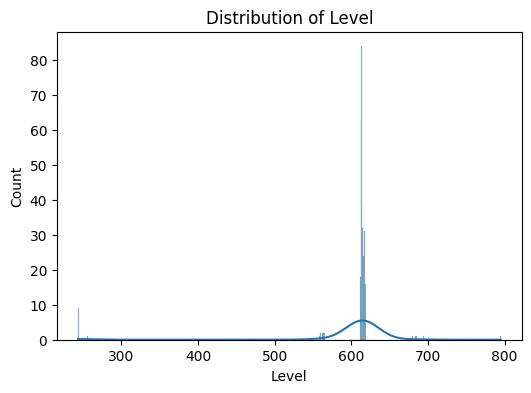

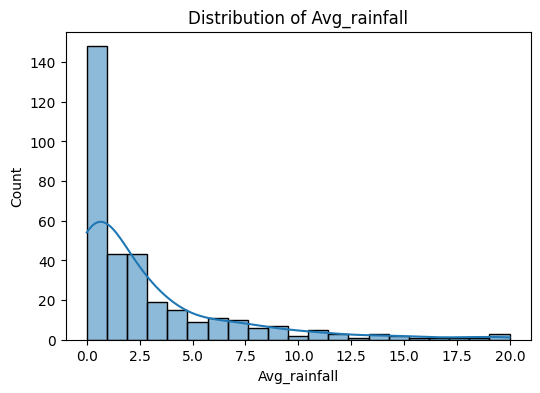

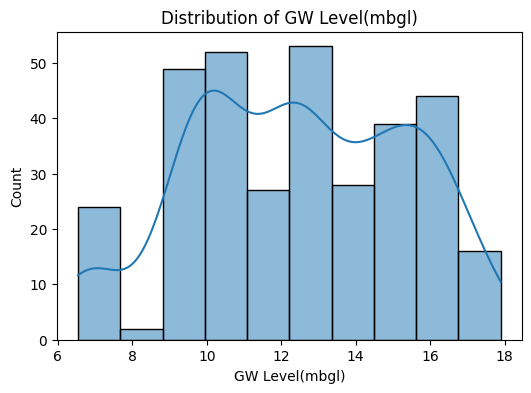

In [ ]:
# Distribution Plots for each column to see the shape of data
cols = ['Level', 'Avg_rainfall', 'GW Level(mbgl)']
for col in cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

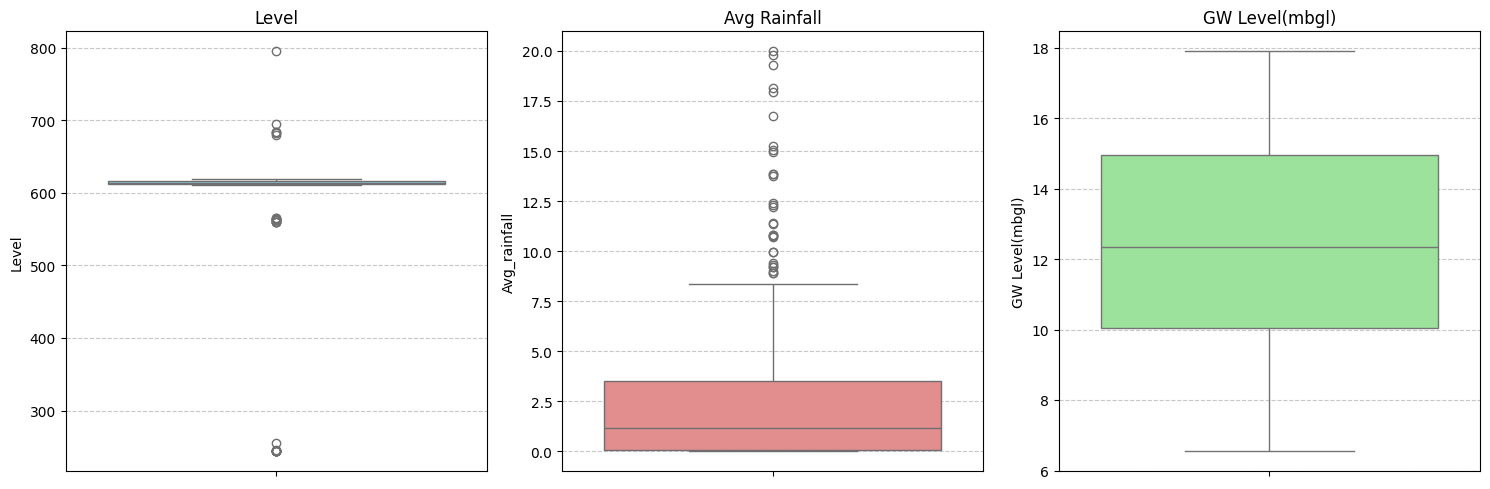

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(y=df["Level"], ax=axes[0], color="skyblue")
axes[0].set_title("Level")

sns.boxplot(y=df["Avg_rainfall"], ax=axes[1], color="lightcoral")
axes[1].set_title("Avg Rainfall")

sns.boxplot(y=df["GW Level(mbgl)"], ax=axes[2], color="lightgreen")
axes[2].set_title("GW Level(mbgl)")

for ax in axes:
    ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

**Bivariate Analysis**

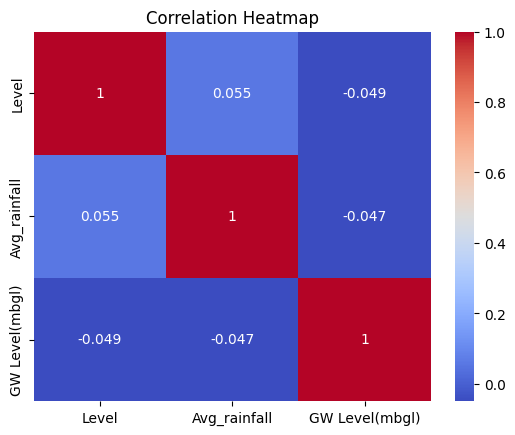

In [ ]:
# Correlation Matrix to see how variables relate

corr_matrix = df[cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

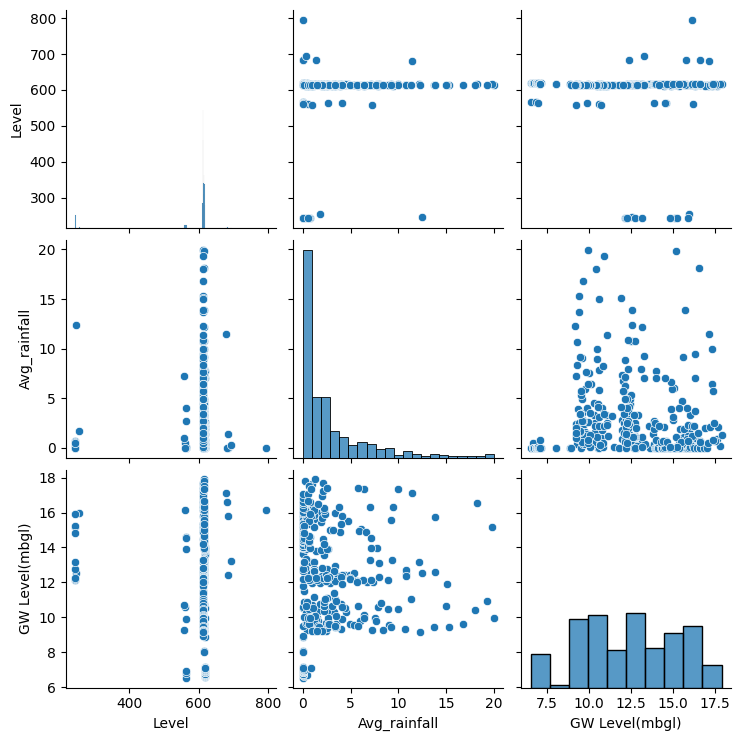

In [ ]:
# Pair Plot for a quick look at pairwise relationships

sns.pairplot(df[cols])
plt.show()

Time-Series Visualization

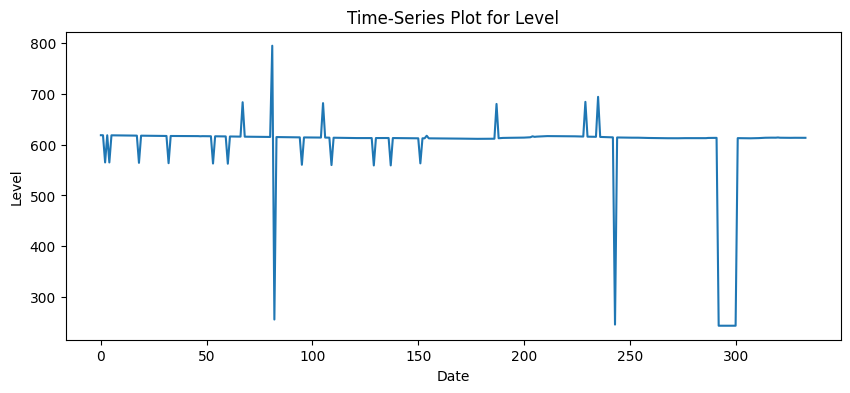

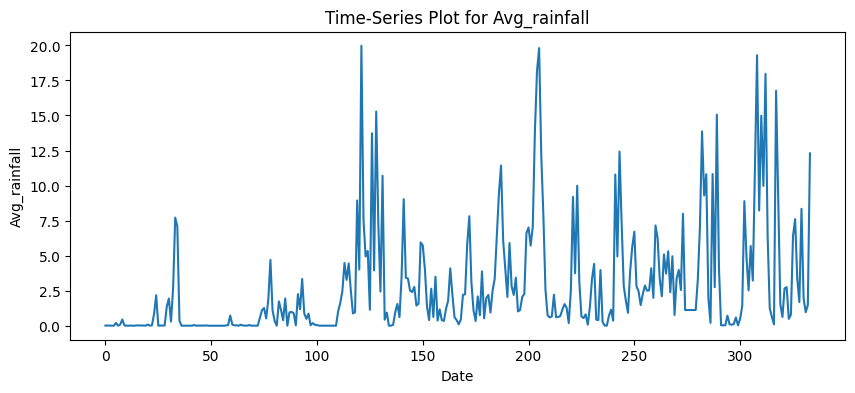

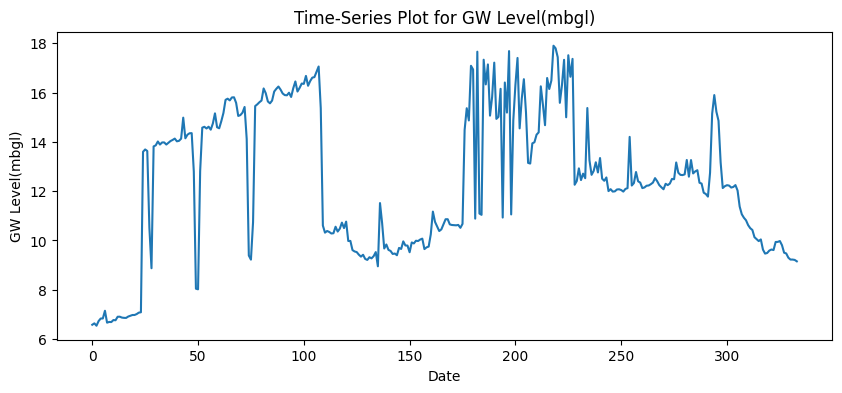

In [ ]:
# line plots

# Assuming df has a DateTime index
for col in cols:
    plt.figure(figsize=(10, 4))
    plt.plot(df.index, df[col])
    plt.title(f"Time-Series Plot for {col}")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.show()

In [ ]:
df.set_index('Date', inplace=True)

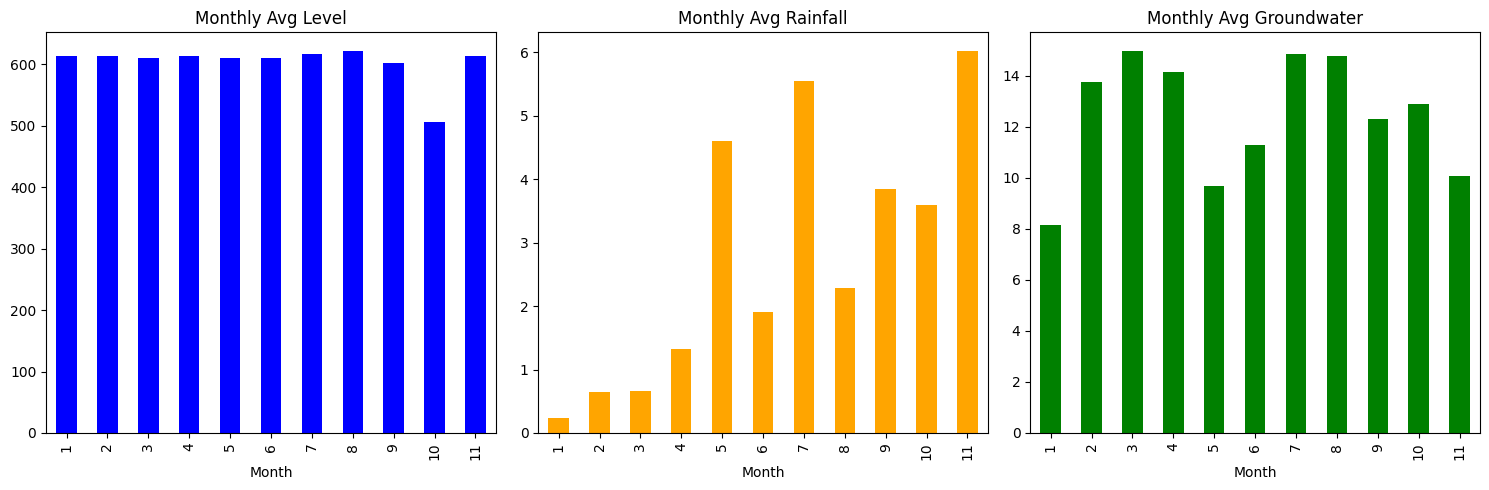

In [ ]:
# Seasonality Checks
df['Month'] = df.index.month
monthly_avg = df.groupby('Month')[cols].mean()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
monthly_avg['Level'].plot(kind='bar', ax=axes[0], color='blue', title='Monthly Avg Level')
monthly_avg['Avg_rainfall'].plot(kind='bar', ax=axes[1], color='orange', title='Monthly Avg Rainfall')
monthly_avg['GW Level(mbgl)'].plot(kind='bar', ax=axes[2], color='green', title='Monthly Avg Groundwater')
plt.tight_layout()
plt.show()

Statistical Tests

In [ ]:
# Augmented Dickey-Fuller (ADF) Test to check if each series is stationary or needs differencing.
# (Stationarity Tests)

from statsmodels.tsa.stattools import adfuller

for col in cols:
    result = adfuller(df[col].dropna())
    print(f"{col} - ADF Statistic: {result[0]}, p-value: {result[1]}")

Level - ADF Statistic: -4.888082945665574, p-value: 3.6785712654631496e-05
Avg_rainfall - ADF Statistic: -2.9070470737623584, p-value: 0.04453463432225558
GW Level(mbgl) - ADF Statistic: -2.9009546104087187, p-value: 0.045237101831908474


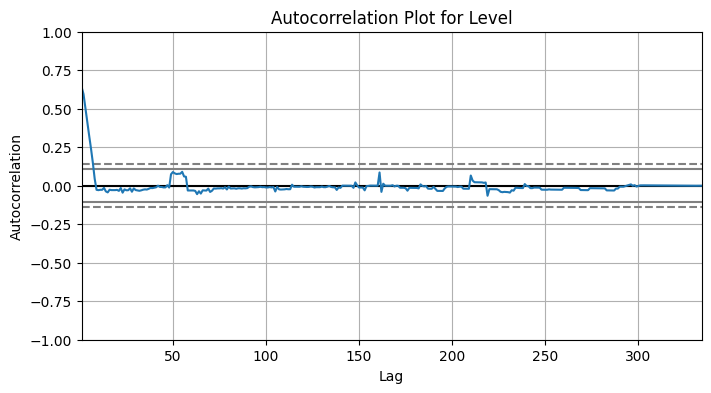

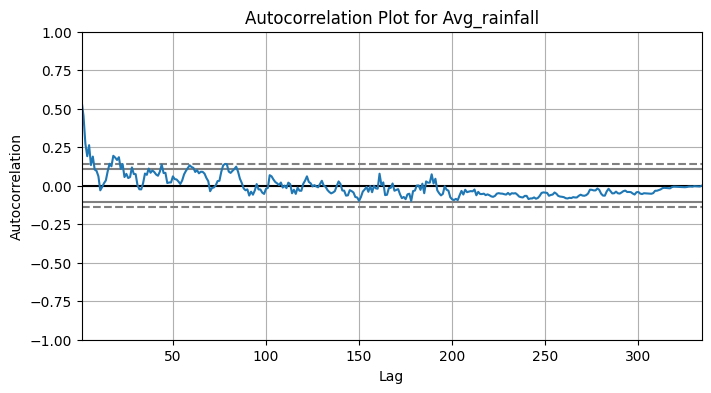

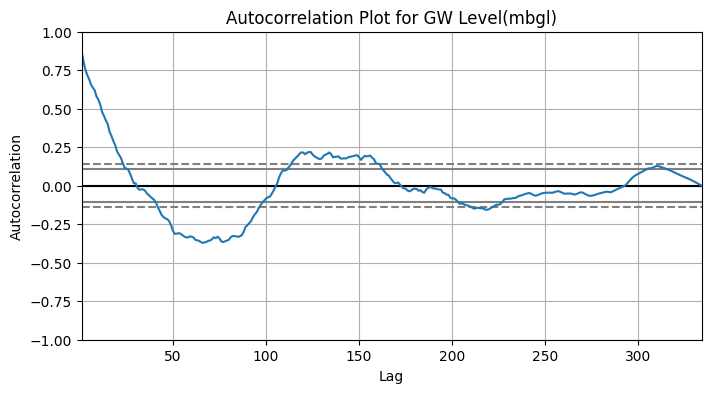

In [ ]:
# Lag Plots/Autocorrelation:
# Autocorrelation helps see if past values influence future values - Partial Autocorrelation can be similarly checked with pacf from statsmodels

from pandas.plotting import autocorrelation_plot

for col in cols:
    plt.figure(figsize=(8,4))
    autocorrelation_plot(df[col].dropna())
    plt.title(f"Autocorrelation Plot for {col}")
    plt.show()


# **Normalization & Visualiazation**

In [ ]:
df.head()

,Basin,Level,Avg_rainfall,GW Level(mbgl),Month
Date,,,,,
2023-01-01,Cauvery Basin,618.709333,0.008804,6.579664,1
2023-01-02,Cauvery Basin,618.626000,0.008804,6.636889,1
2023-01-03,Cauvery Basin,565.101800,0.012438,6.540578,1
2023-01-04,Cauvery Basin,618.621500,0.000033,6.729337,1
2023-01-05,Cauvery Basin,565.077800,0.000033,6.833225,1


In [ ]:
df = df.drop(['Month','Basin'], axis=1)
df.head()

,Level,Avg_rainfall,GW Level(mbgl)
Date,,,
2023-01-01,618.709333,0.008804,6.579664
2023-01-02,618.626000,0.008804,6.636889
2023-01-03,565.101800,0.012438,6.540578
2023-01-04,618.621500,0.000033,6.729337
2023-01-05,565.077800,0.000033,6.833225


**Normalizing**

In [ ]:
sc = MinMaxScaler()
scaled_df = sc.fit_transform(df[df.columns])
scaled_df

array([[6.80382575e-01, 4.39510615e-04, 3.44127805e-03],
       [6.80231446e-01, 4.39510615e-04, 8.47956905e-03],
       [5.83162421e-01, 6.21392989e-04, 0.00000000e+00],
       ...,
       [6.71180905e-01, 4.81493879e-02, 2.36276656e-01],
       [6.71145843e-01, 7.39503732e-02, 2.35025047e-01],
       [6.71086902e-01, 6.15299061e-01, 2.29990058e-01]])

In [ ]:
#convert back to dataframe
df = pd.DataFrame(scaled_df, columns = df.columns, index = df.index)
df.head()

,Level,Avg_rainfall,GW Level(mbgl)
Date,,,
2023-01-01,0.680383,4.395106e-04,0.003441
2023-01-02,0.680231,4.395106e-04,0.008480
2023-01-03,0.583162,6.213930e-04,0.000000
2023-01-04,0.680223,4.650668e-07,0.016619
2023-01-05,0.583119,4.650668e-07,0.025766


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 2023-01-01 to 2023-11-30
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Level           334 non-null    float64
 1   Avg_rainfall    334 non-null    float64
 2   GW Level(mbgl)  334 non-null    float64
dtypes: float64(3)
memory usage: 10.4 KB


**Plotting the columns**

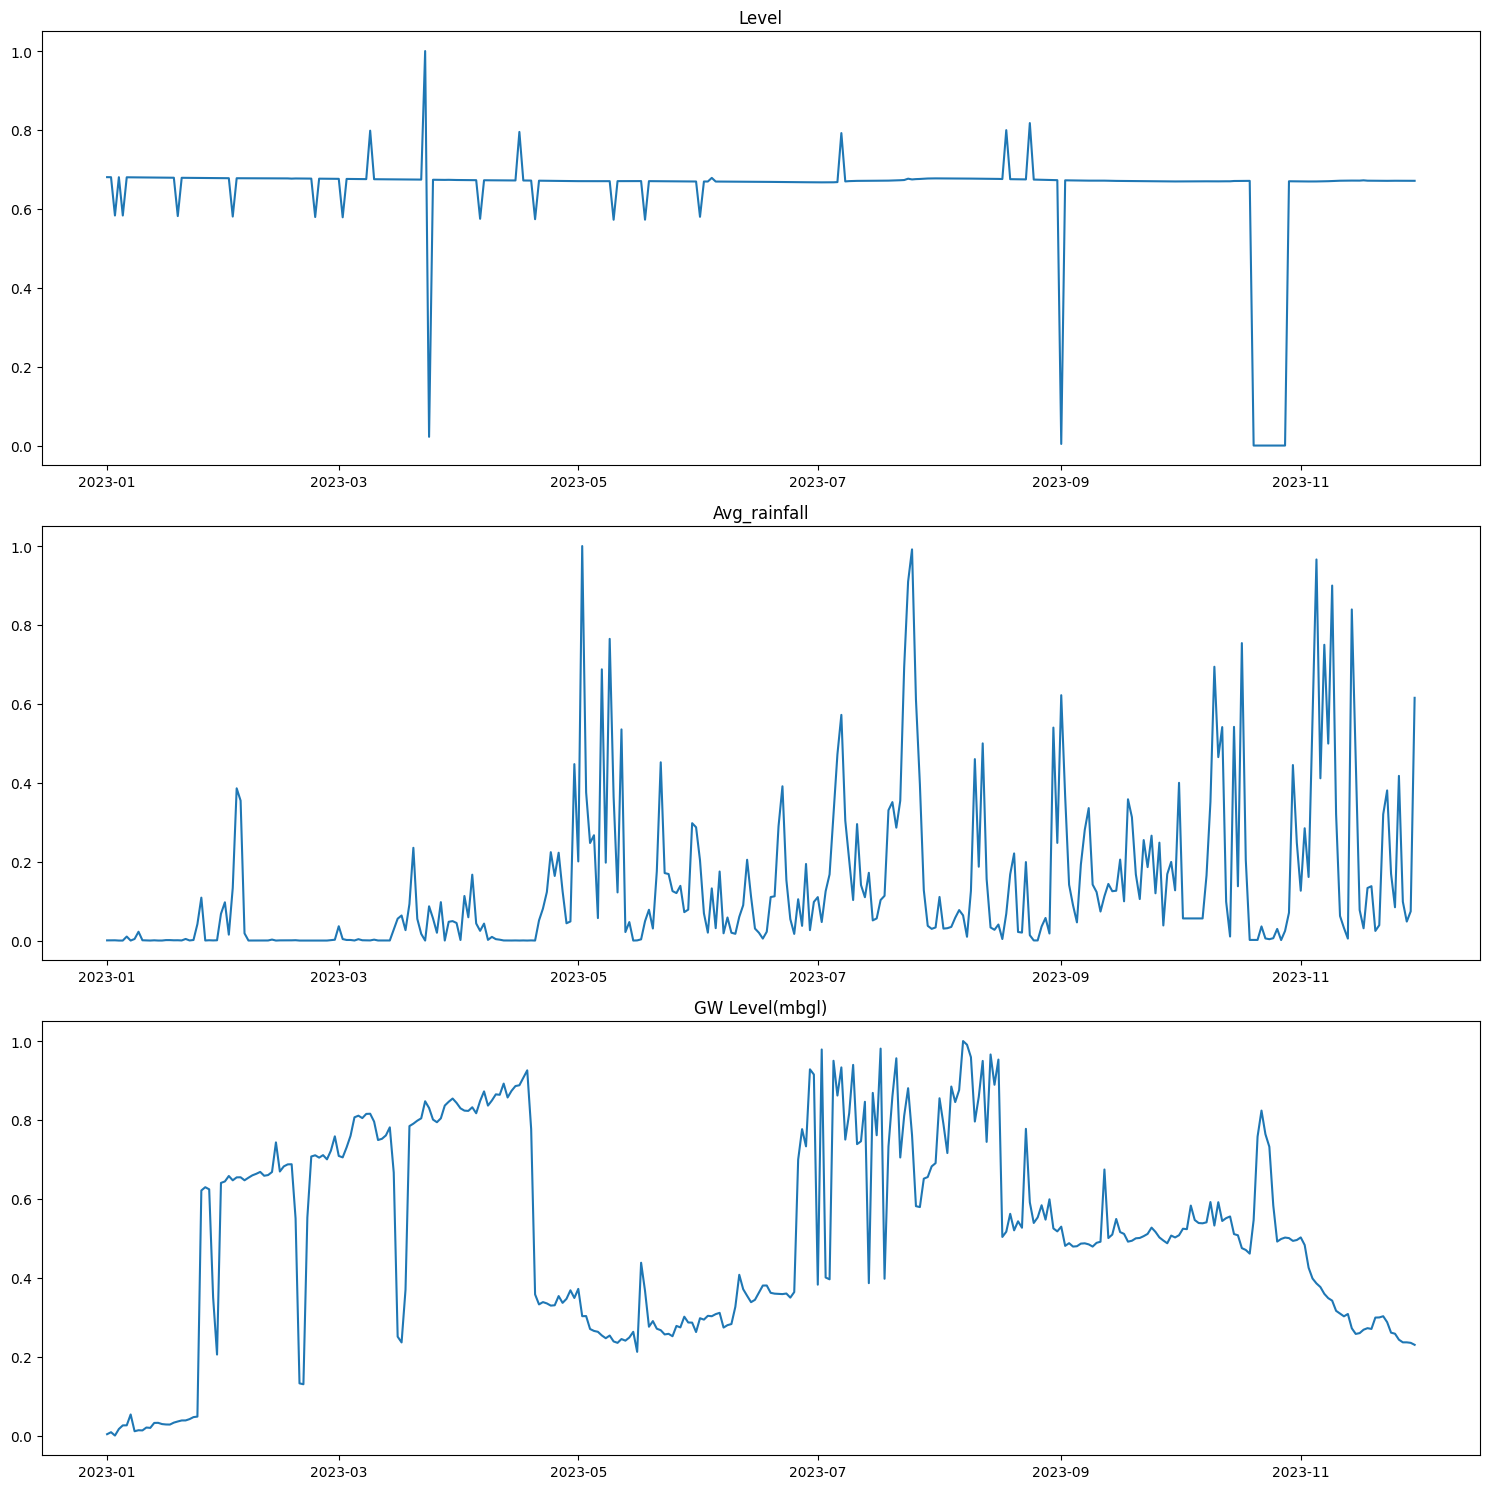

In [ ]:
plt.rcParams['figure.figsize'] = (15,15)
figure, axes = plt.subplots(3)

for ax, col in zip(axes, df.columns):
  ax.plot(df[col])
  ax.set_title(col)
  #ax.axes.xaxis.set_visible(False)

plt.tight_layout()

# **IMF**

In [ ]:
pip install EMD-signal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.3 MB/s eta 0:00:00


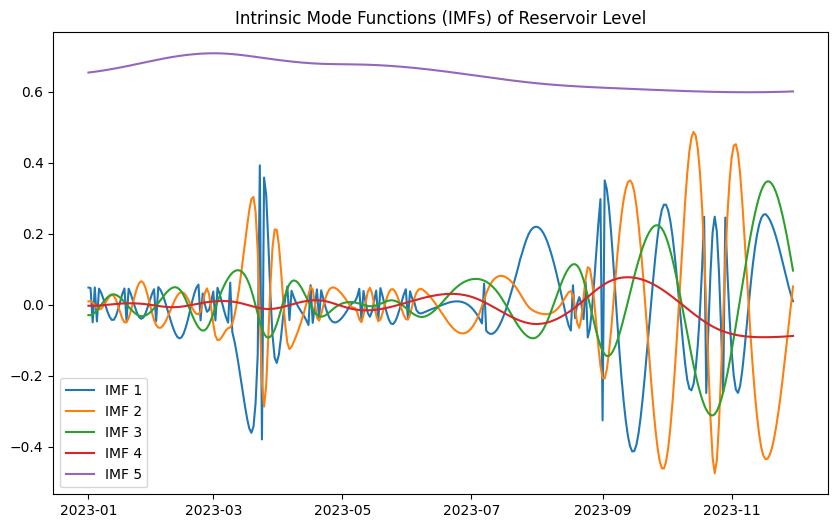

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PyEMD import EMD

# Load your dataframe (assuming it's already loaded as df)
level_series = df['Level'].values

# Apply EMD decomposition
emd = EMD()
emd.FIXE_H = 5  # At least 5 iterations per IMF (you can adjust)
IMFs = emd(level_series)  # Decomposed IMFs

# Convert IMFs into a DataFrame for further processing
imf_df = pd.DataFrame(IMFs.T, index=df.index, columns=[f'IMF_{i+1}' for i in range(IMFs.shape[0])])

# Add other relevant features to the dataset
for col in ['Avg_rainfall', 'GW Level(mbgl)']:
    imf_df[col] = df[col]

# Plot IMFs to visualize decomposition
plt.figure(figsize=(10, 6))
for i in range(IMFs.shape[0]):
    plt.plot(df.index, IMFs[i], label=f'IMF {i+1}')
plt.legend()
plt.title('Intrinsic Mode Functions (IMFs) of Reservoir Level')
plt.show()

# imf_df is now ready to be used as input for LSTM

In [ ]:
print(imf_df.head())

               IMF_1     IMF_2     IMF_3     IMF_4     IMF_5  Avg_rainfall  \
Date                                                                         
2023-01-01  0.048423  0.009475 -0.029188 -0.002962  0.654634  4.395106e-04   
2023-01-02  0.047155  0.010321 -0.029515 -0.003080  0.655350  4.395106e-04   
2023-01-03 -0.049622  0.006785 -0.027062 -0.003044  0.656105  6.213930e-04   
2023-01-04  0.048891 -0.000402 -0.022295 -0.002869  0.656899  4.650668e-07   
2023-01-05 -0.047214 -0.008972 -0.015849 -0.002574  0.657728  4.650668e-07   

            GW Level(mbgl)  
Date                        
2023-01-01        0.003441  
2023-01-02        0.008480  
2023-01-03        0.000000  
2023-01-04        0.016619  
2023-01-05        0.025766  


In [ ]:
df_final = imf_df[['IMF_3', 'Avg_rainfall', 'GW Level(mbgl)']]
df_final.columns = ['Reservoir', 'Rainfall', 'GW Level']
print(df_final.head())

            Reservoir      Rainfall  GW Level
Date                                         
2023-01-01  -0.029188  4.395106e-04  0.003441
2023-01-02  -0.029515  4.395106e-04  0.008480
2023-01-03  -0.027062  6.213930e-04  0.000000
2023-01-04  -0.022295  4.650668e-07  0.016619
2023-01-05  -0.015849  4.650668e-07  0.025766


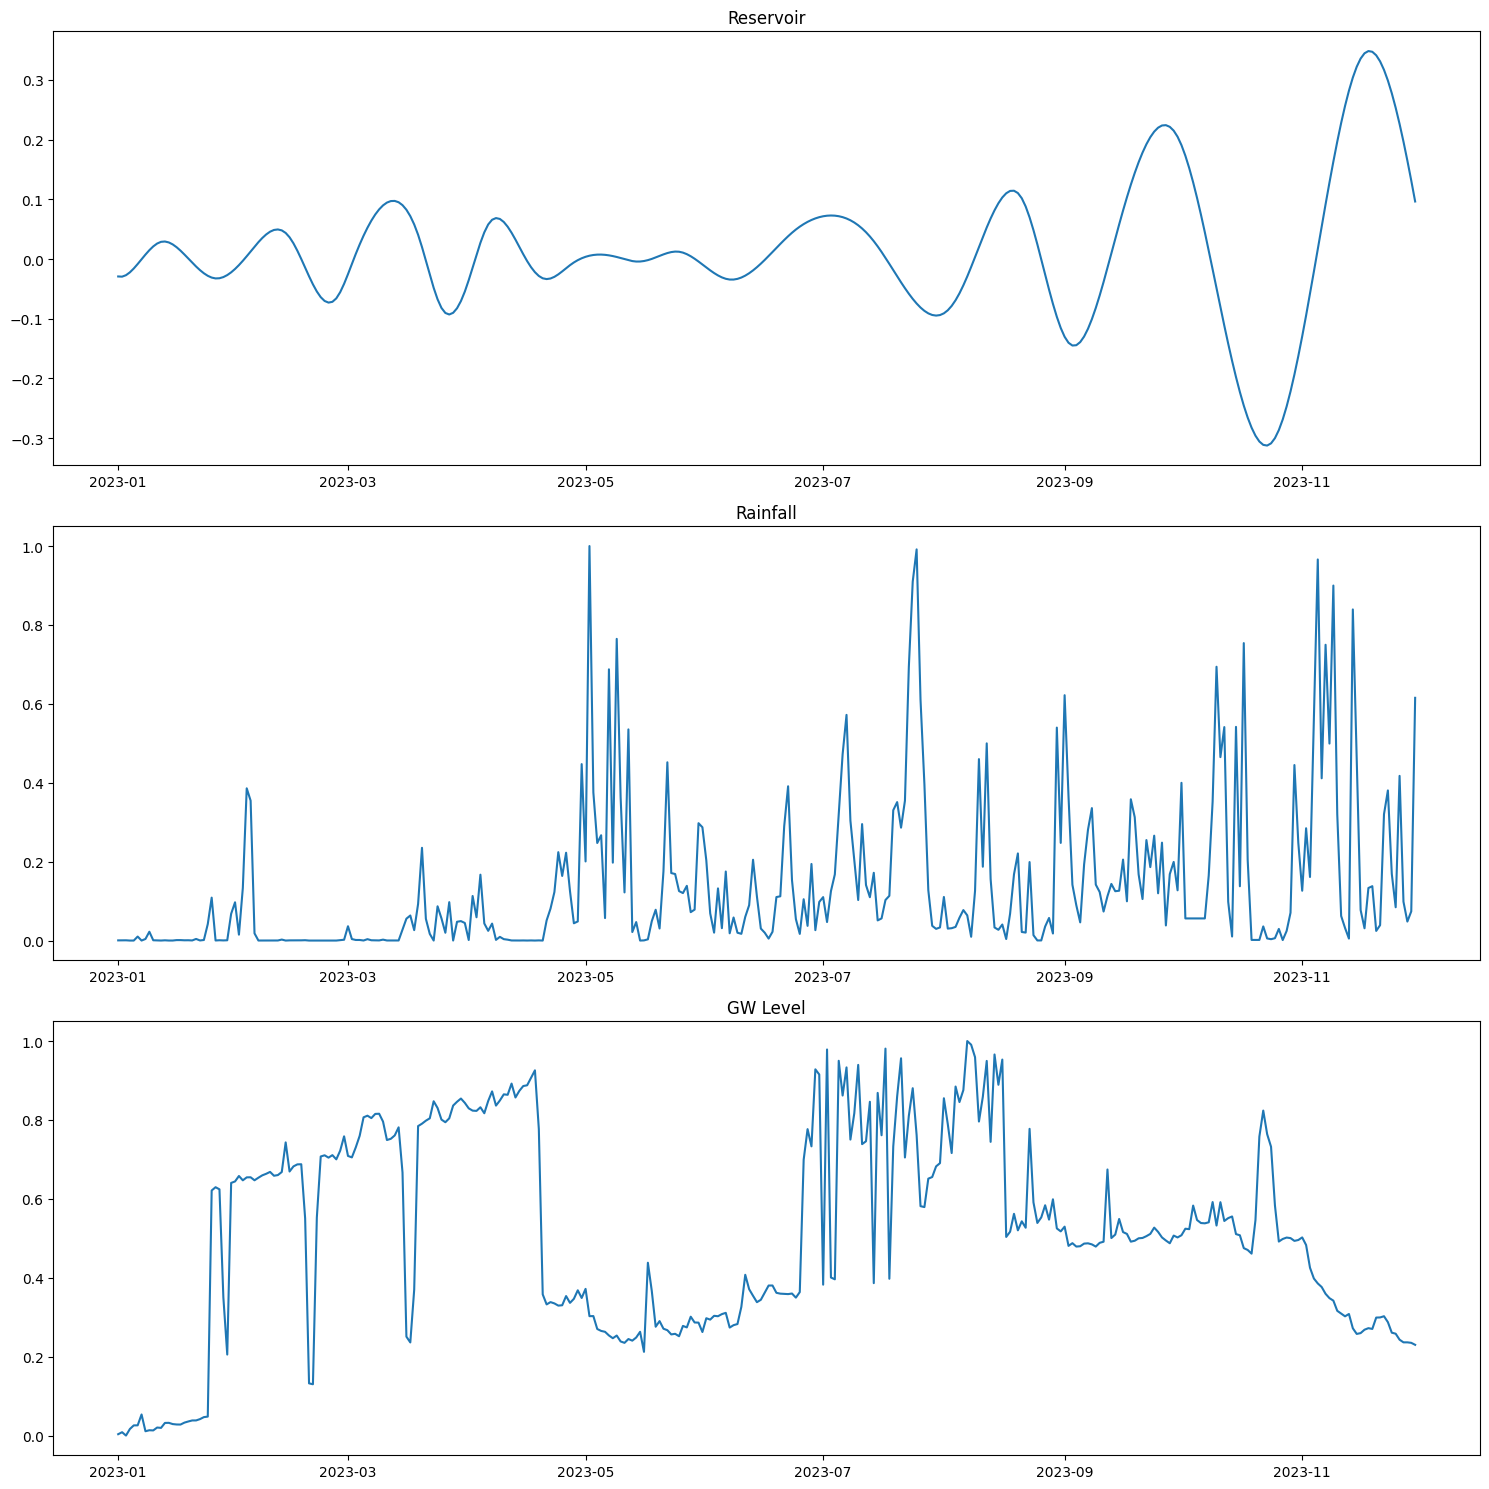

In [ ]:
plt.rcParams['figure.figsize'] = (15,15)
figure, axes = plt.subplots(3)

for ax, col in zip(axes, df_final.columns):
  ax.plot(df_final[col])
  ax.set_title(col)
  #ax.axes.xaxis.set_visible(False)

plt.tight_layout()

# **Log Transformation**

The rainfall data is very skewed, meaning you may need log transformation or normalization for better modeling.

Log transformation is used to reduce skewness in data, especially when the distribution is heavily right-skewed (many small values and a few large ones)

Log of 0 is undefined, so adding 1 ensures that zero values do not cause errors.

In [ ]:
df_final['log_rainfall'] = np.log(df_final['Rainfall'] + 1)  # Adding 1 to avoid log(0) issue

<ipython-input-40-3ca34127ee20>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['log_rainfall'] = np.log(df_final['Rainfall'] + 1)  # Adding 1 to avoid log(0) issue


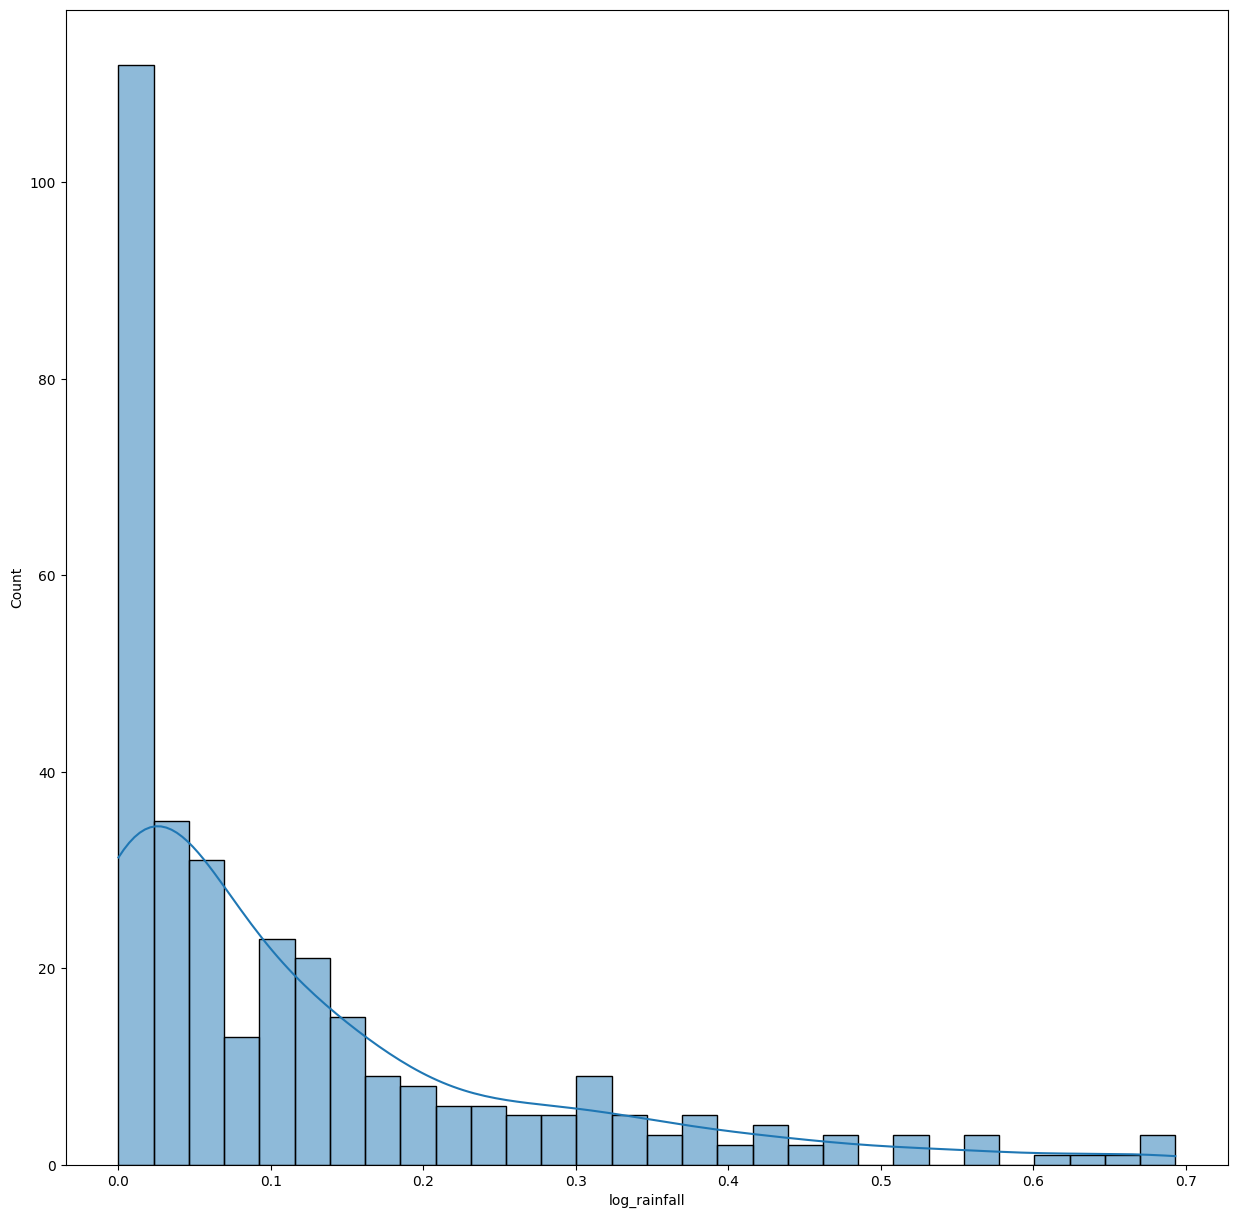

In [ ]:
#check skewness now
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_final['log_rainfall'], bins=30, kde=True)
plt.show()

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 2023-01-01 to 2023-11-30
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Reservoir     334 non-null    float64
 1   Rainfall      334 non-null    float64
 2   GW Level      334 non-null    float64
 3   log_rainfall  334 non-null    float64
dtypes: float64(4)
memory usage: 13.0 KB


In [ ]:
df = df_final.drop(columns=['Rainfall'])  # Remove Avg_rainfall column
df = df.rename(columns={'log_rainfall': 'Rainfall'})  # Rename columns
df = df[['Reservoir', 'Rainfall', 'GW Level']]  # Reorder columns

In [ ]:
df.head()

,Reservoir,Rainfall,GW Level
Date,,,
2023-01-01,-0.029188,4.394141e-04,0.003441
2023-01-02,-0.029515,4.394141e-04,0.008480
2023-01-03,-0.027062,6.212000e-04,0.000000
2023-01-04,-0.022295,4.650667e-07,0.016619
2023-01-05,-0.015849,4.650667e-07,0.025766


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 2023-01-01 to 2023-11-30
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Reservoir  334 non-null    float64
 1   Rainfall   334 non-null    float64
 2   GW Level   334 non-null    float64
dtypes: float64(3)
memory usage: 10.4 KB


In [ ]:
#Saving this data to drive

df.to_csv('/content/drive/MyDrive/Dataset/New Data/Final2.csv', index=True)

# **PreProcessing**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/New Data/Final2.csv')
df.head()

,Date,Reservoir,Rainfall,GW Level
0,2023-01-01,-0.029188,4.394141e-04,0.003441
1,2023-01-02,-0.029515,4.394141e-04,0.008480
2,2023-01-03,-0.027062,6.212000e-04,0.000000
3,2023-01-04,-0.022295,4.650667e-07,0.016619
4,2023-01-05,-0.015849,4.650667e-07,0.025766


In [ ]:
df.set_index('Date', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 334 entries, 2023-01-01 to 2023-11-30
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Reservoir  334 non-null    float64
 1   Rainfall   334 non-null    float64
 2   GW Level   334 non-null    float64
dtypes: float64(3)
memory usage: 10.4+ KB


**Creating Sliding Sequences**

In [ ]:
def create_sequence(data, window_size):
  X = []
  y = []
  for i in range(window_size, len(data)):
    X.append(data.iloc[i-window_size:i].values)
    y.append(data.iloc[i].values)
  return np.array(X), np.array(y)

In [ ]:
window_size = 3
X, y = create_sequence(df, window_size)
X.shape, y.shape

((331, 3, 3), (331, 3))

**Train Test Split**

In [ ]:
# 1. Determine the split index (80% train, 20% test)
split_index = int(len(X) * 0.8)

# 2. Slice the data
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# **Define and Train the Model**

In [ ]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32, return_sequences=False),
    Dense(y_train.shape[1])
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Compilation
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['RootMeanSquaredError', 'mean_absolute_error', 'mean_squared_error'])

In [ ]:
#Early Stopping Condition
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 50, restore_best_weights = True)

In [ ]:
checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Dataset/Model/model-last5.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

Load the entire model (architecture + weights)

```
from tensorflow.keras.models import load_model
best_model = load_model('./model.keras')
```
Suppose you have some test data (same shape as training input)

```
predictions = best_model.predict(X_test)
print(predictions)
```
Compile again if needed (the optimizer state is not always fully preserved)


```
best_model.compile(optimizer='adam', loss='huber_loss', metrics=['RootMeanSquaredError', 'mean_absolute_error'])
```



Continue training


```
history = best_model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))
```






In [ ]:
split_index_val = int(len(X_train) * 0.8)

X_train_final = X_train[:split_index_val]
X_val = X_train[split_index_val:]
y_train_final = y_train[:split_index_val]
y_val = y_train[split_index_val:]

history = model.fit(
    X_train_final,
    y_train_final,
    epochs=120,
    batch_size=2,
    validation_data=(X_val, y_val),
    shuffle=False,
    callbacks = [early_stopping, checkpoint, reduce_lr]
)

Epoch 1/120
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - RootMeanSquaredError: 0.0787 - loss: 0.0066 - mean_absolute_error: 0.0420 - mean_squared_error: 0.0066
Epoch 1: val_loss did not improve from 0.00772
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - RootMeanSquaredError: 0.0788 - loss: 0.0066 - mean_absolute_error: 0.0421 - mean_squared_error: 0.0066 - val_RootMeanSquaredError: 0.0879 - val_loss: 0.0077 - val_mean_absolute_error: 0.0647 - val_mean_squared_error: 0.0077 - learning_rate: 1.0000e-06
Epoch 2/120
105/106 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - RootMeanSquaredError: 0.0785 - loss: 0.0066 - mean_absolute_error: 0.0418 - mean_squared_error: 0.0066
Epoch 2: val_loss did not improve from 0.00772
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - RootMeanSquaredError: 0.0788 - loss: 0.0066 - mean_absolute_error: 0.0420 - mean_squared_error: 0.0066 - val_RootMeanSquaredError: 0.0879 - val_loss: 0.0077 - val_mean_absolute_error: 0.0647 - val_mean_squared_error: 0.0077 - learning_rate: 1.0000e-06

# **Testing**

In [ ]:
our_model = load_model('/content/drive/MyDrive/Dataset/Model/model-last5.keras')

In [ ]:
prediction = our_model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 401ms/step


In [ ]:
#Inverse
pred = sc.inverse_transform(prediction)
actual = sc.inverse_transform(y_test)

In [ ]:
pred[:2]

array([[313.39883  ,   3.7771935,  14.724564 ],
       [314.62518  ,   3.3824854,  14.685319 ]], dtype=float32)

In [ ]:
print(df.columns)

Index(['Reservoir', 'Rainfall', 'GW Level'], dtype='object')


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


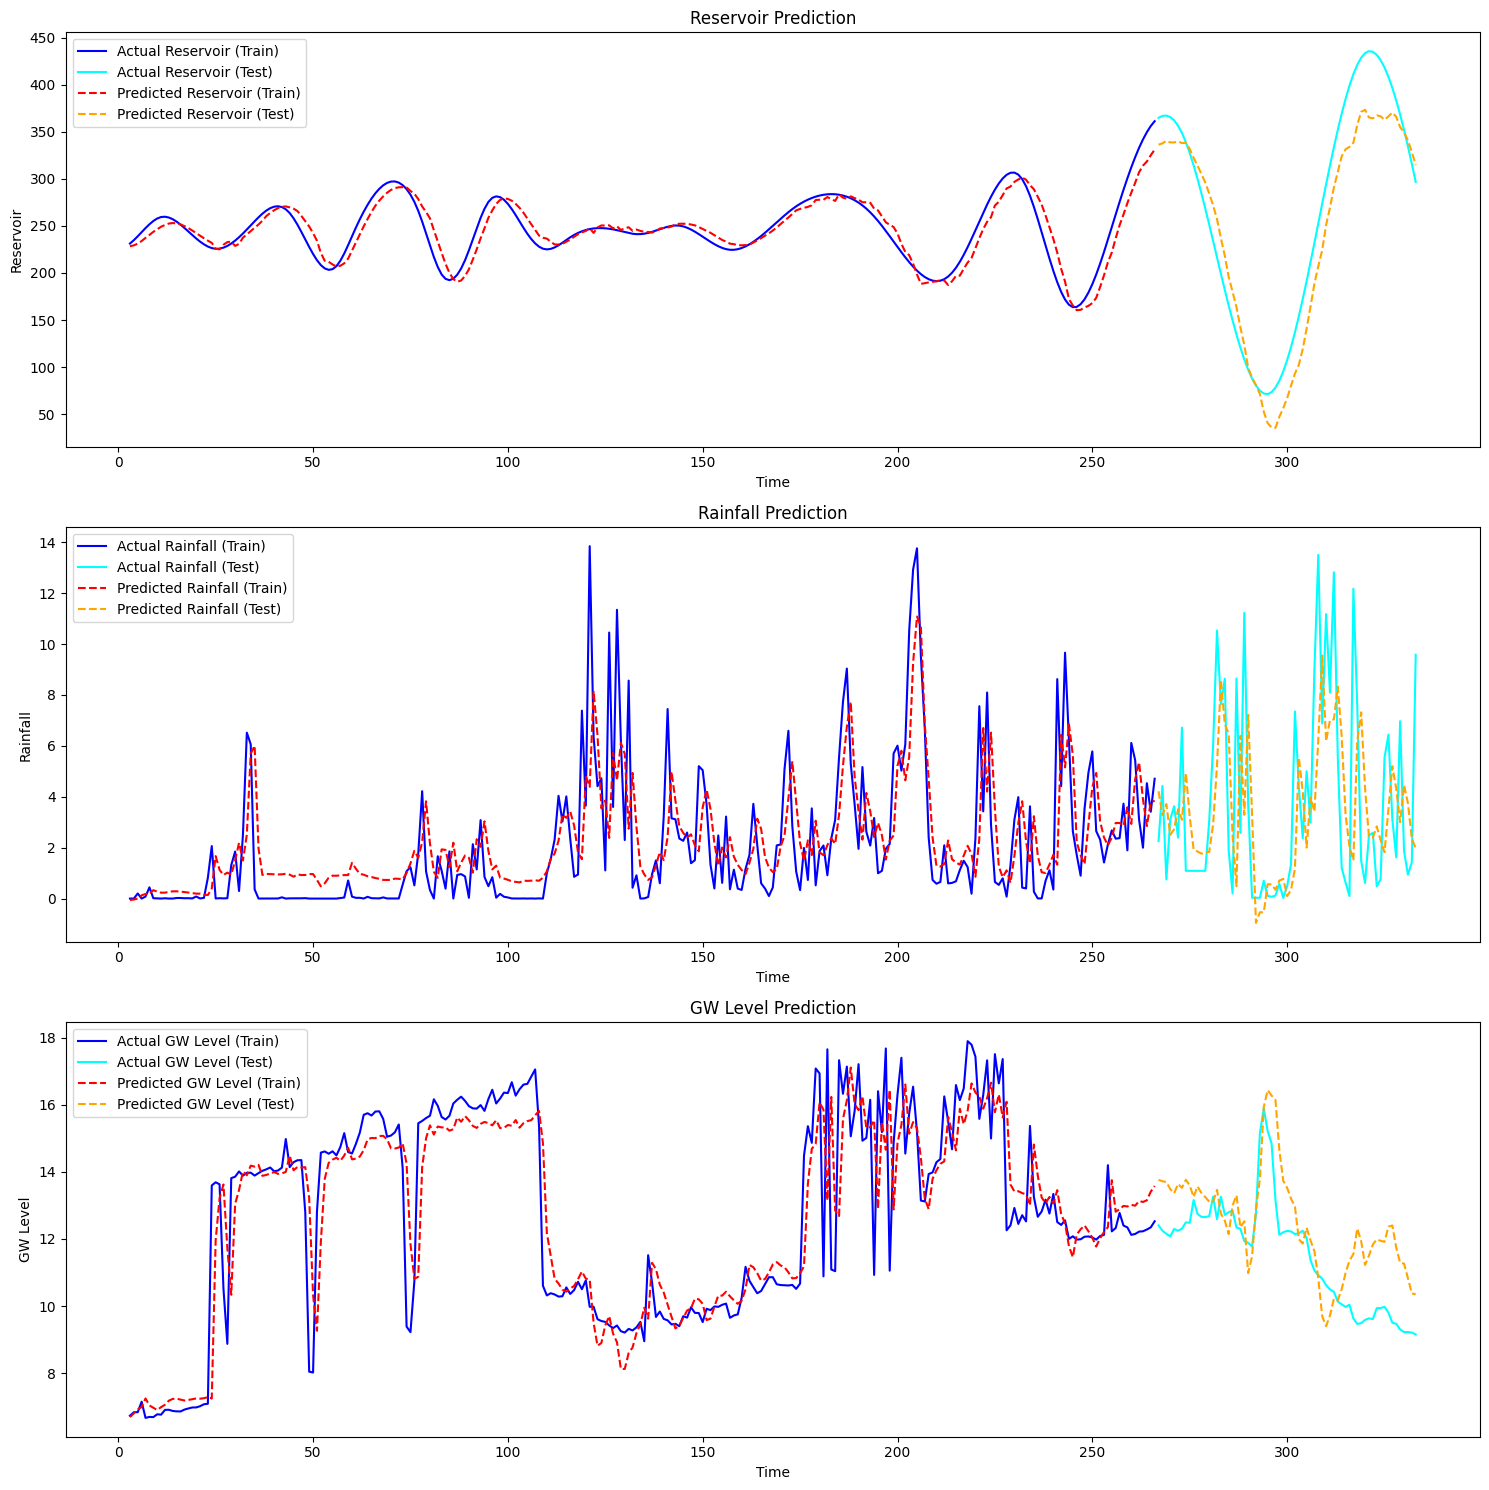

In [ ]:
# Step 1: Adjust timeline to match sequence data
timeline = np.arange(window_size, len(df_final))  # Start from window_size

# Step 2: Define split index based on the adjusted timeline
split_index = int(len(timeline) * 0.8)

# Step 3: Predict training and test data
train_predictions = our_model.predict(X_train)
test_predictions = our_model.predict(X_test)

# Step 4: Inverse transform predictions and actual values
train_pred = sc.inverse_transform(train_predictions)
test_pred = sc.inverse_transform(test_predictions)
actual_train = sc.inverse_transform(y_train)
actual_test = sc.inverse_transform(y_test)

# Step 5: Plot actual vs predicted values
plt.rcParams['figure.figsize'] = (15, 15)
for i, col in enumerate(df.columns):
    plt.subplot(len(df.columns), 1, i+1)

    # Plot actual values
    plt.plot(timeline[:split_index], actual_train[:, i], color='blue', label=f'Actual {col} (Train)')
    plt.plot(timeline[split_index:], actual_test[:, i], color='cyan', label=f'Actual {col} (Test)')

    # Plot predicted values
    plt.plot(timeline[:split_index], train_pred[:, i], color='red', linestyle='dashed', label=f'Predicted {col} (Train)')
    plt.plot(timeline[split_index:], test_pred[:, i], color='orange', linestyle='dashed', label=f'Predicted {col} (Test)')

    plt.title(f'{col} Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{col}')
    plt.legend()

plt.tight_layout()
plt.show()


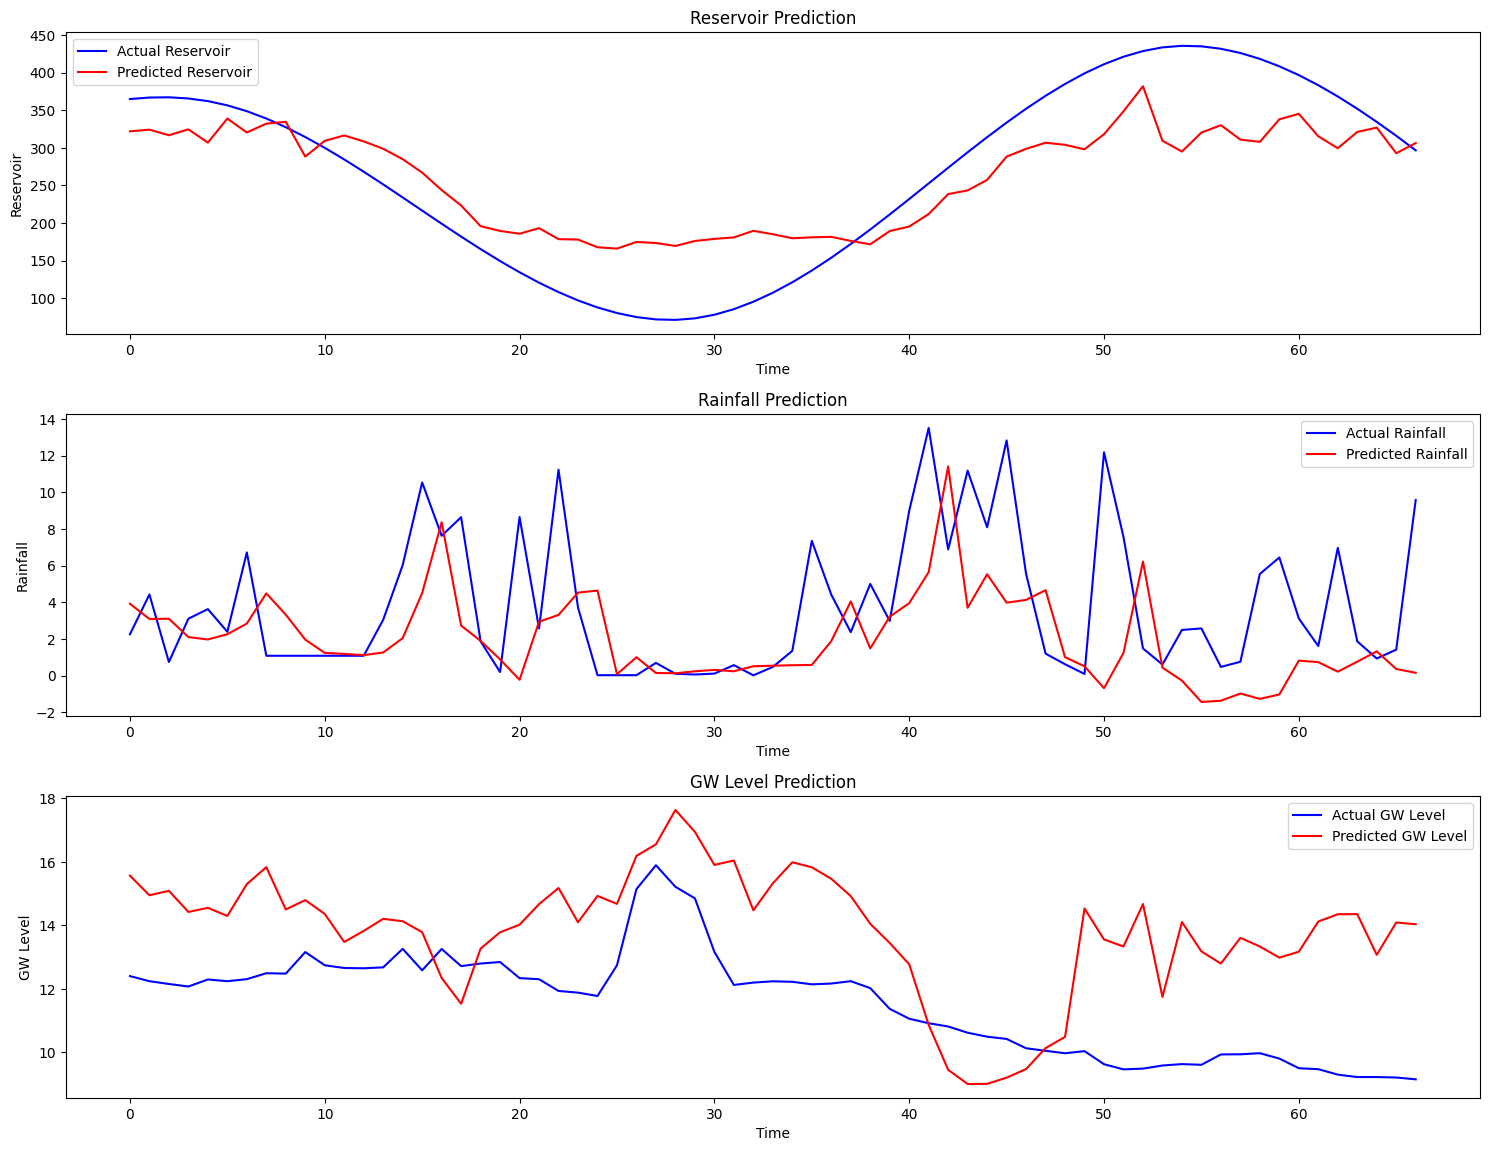

In [ ]:
#Plotting the results
plt.rcParams['figure.figsize'] = (15,15)
for i, col in enumerate(df.columns):
  plt.subplot(4, 1, i+1)
  plt.plot(actual[:, i], color = 'blue', label = f'Actual {col}')
  plt.plot(pred[:,i], color = 'red', label = f'Predicted {col}')
  plt.title(f'{col} Prediction')
  plt.xlabel('Time')
  plt.ylabel(f'{col}')
  plt.legend()

plt.tight_layout()
plt.show()

# **Evaluate**

In [ ]:
test_loss, test_rmse, test_mae, test_mse = our_model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss (MSE): {test_loss}")  # Loss function (MSE)
print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")
print(f"Test MSE: {test_mse}")  # Extracted from metrics

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - RootMeanSquaredError: 0.1249 - loss: 0.0157 - mean_absolute_error: 0.0941 - mean_squared_error: 0.0157
Test Loss (MSE): 0.01710166595876217
Test RMSE: 0.13077333569526672
Test MAE: 0.09958826005458832
Test MSE: 0.01710166595876217


The model appears to perform well, given the low loss, RMSE, and MAE.
If the target variable has small values (e.g., between 0 and 1), then an RMSE of 0.1897 and MAE of 0.1491 indicate a good fit.

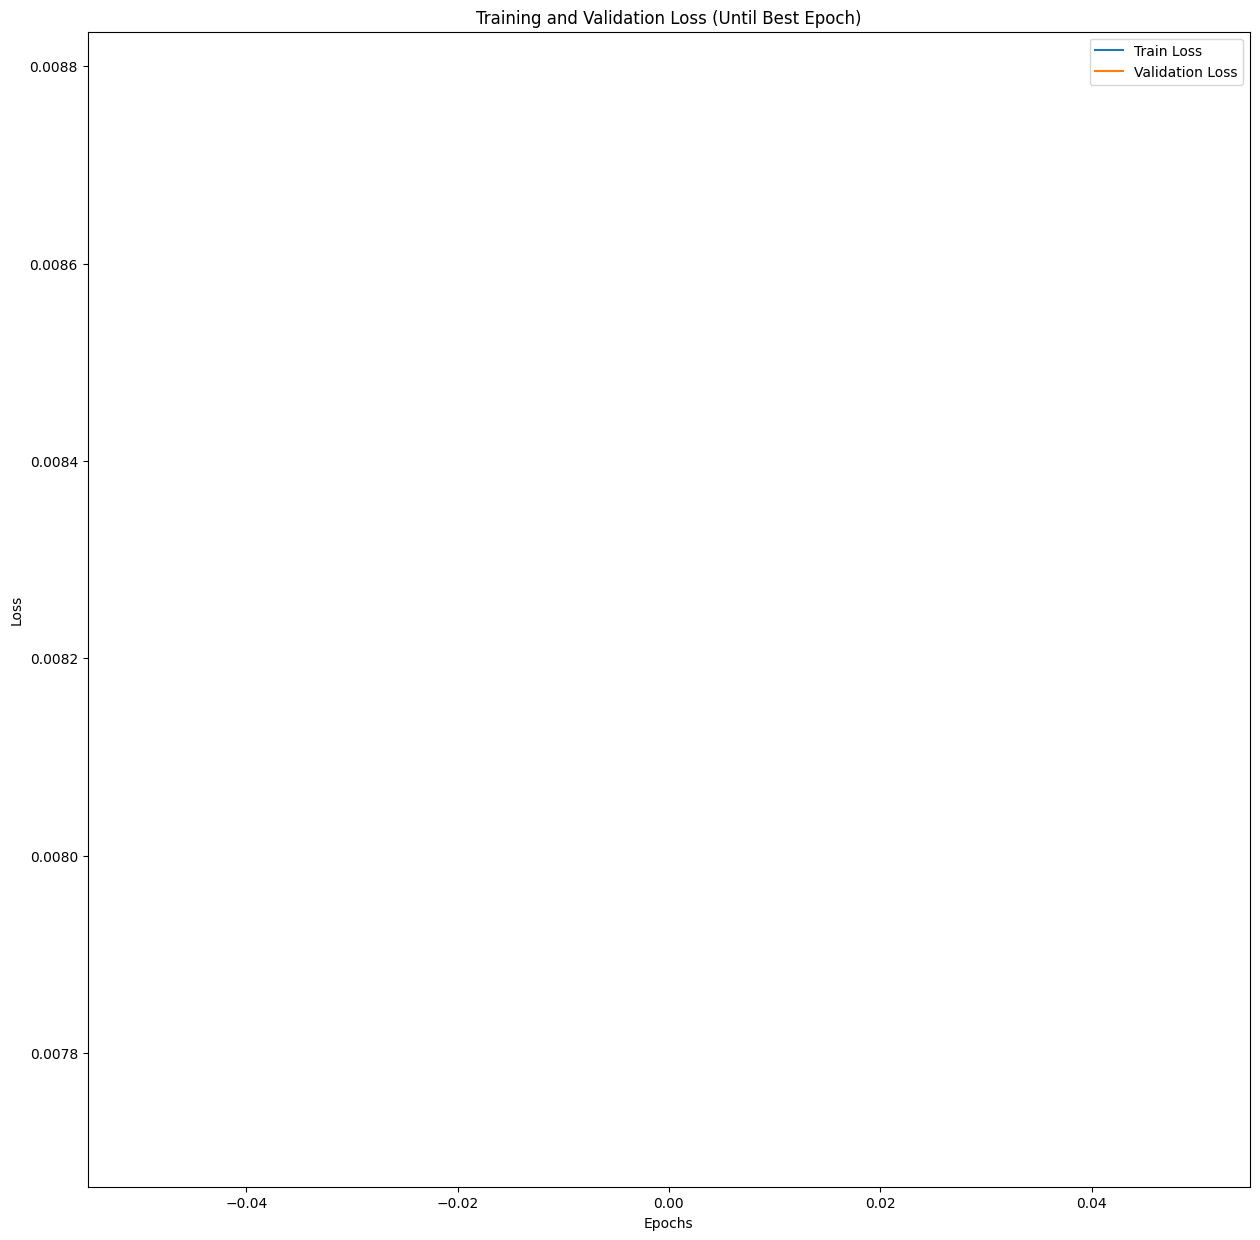

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract losses
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Find the epoch with the lowest validation loss
best_epoch = np.argmin(val_loss)

# Plot only up to the best epoch
plt.plot(train_loss[:best_epoch+1], label='Train Loss')
plt.plot(val_loss[:best_epoch+1], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Until Best Epoch)')
plt.legend()
plt.show()

# **Beyond Seen Data**

**For next Month**

In [ ]:
print(X_test[-1])
print(X_test[-1].shape)
last_window = X_test[-1].reshape(1, window_size, X_test.shape[2])
print(last_window.shape)

[[0.19655633 0.09390411 0.23626737]
 [0.16486469 0.04702612 0.23627666]
 [0.13134799 0.07134379 0.23502505]]
(3, 3)
(1, 3, 3)


In [ ]:
def predict_future(model, last_window, future_steps):
    input_seq = last_window.copy()
    future_predictions = []

    for _ in range(future_steps):
        pred = model.predict(input_seq)

        future_predictions.append(pred[0, :])

        input_seq = np.roll(input_seq, -1, axis=1)
        input_seq[0, -1, :] = pred

    return np.array(future_predictions)

In [ ]:
future_steps = 31
future_preds = predict_future(our_model, last_window, future_steps)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━

In [ ]:
print(future_preds.shape)

(31, 3)


In [ ]:
future_preds_sc = sc.inverse_transform(future_preds)

In [ ]:
if y_test.ndim == 3:  # If shape is (331, 3, 3), reshape to (331, 3)
    y_test = y_test[:, -1, :]

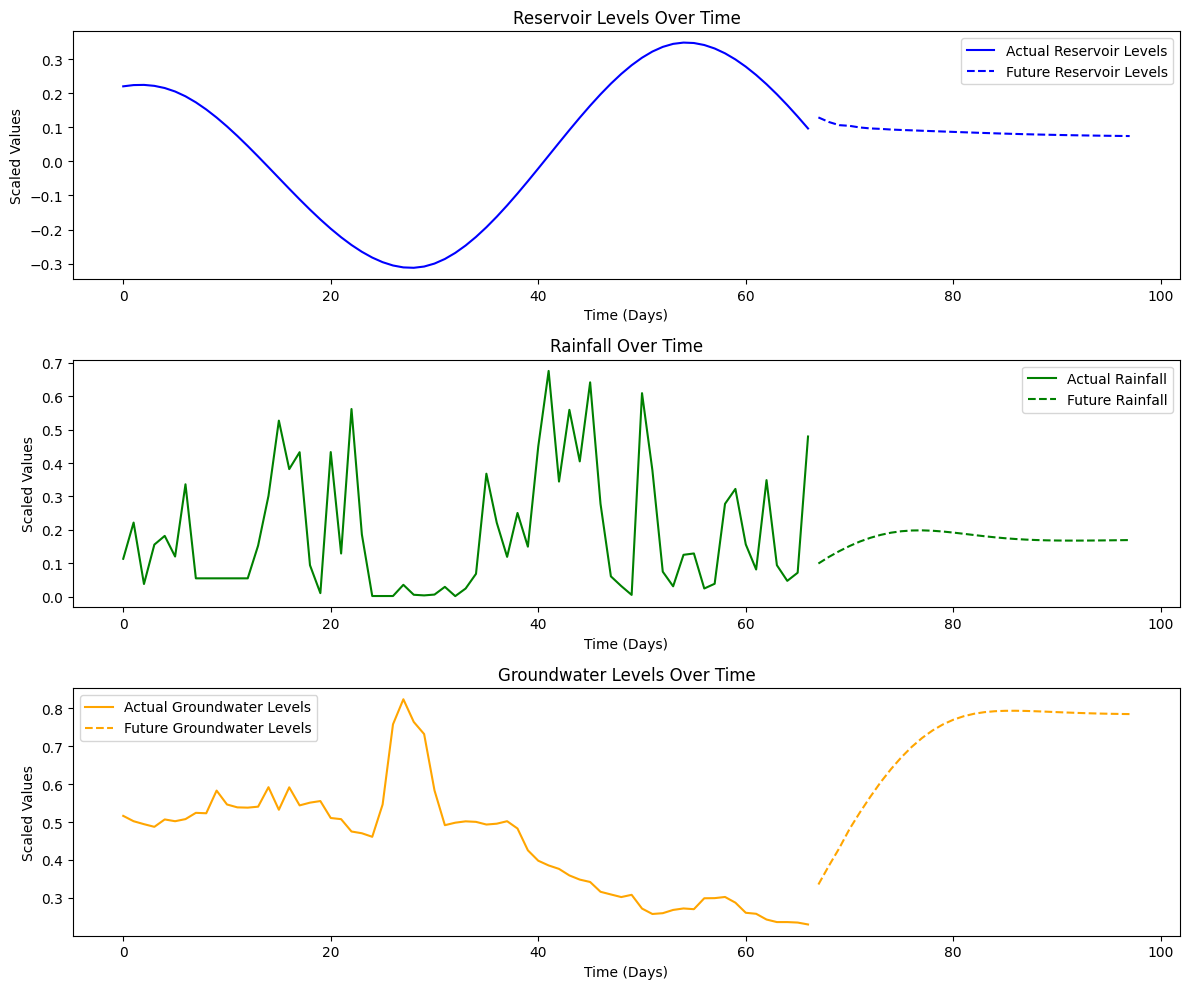

In [ ]:
plt.figure(figsize=(12, 10))
colors = ['blue', 'green', 'orange']
labels = ['Reservoir Levels', 'Rainfall', 'Groundwater Levels']

actual_days = np.arange(len(y_test))
future_days = np.arange(len(y_test), len(y_test) + len(future_preds))

for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(actual_days, y_test[:, i], color=colors[i], label=f"Actual {labels[i]}")
    plt.plot(future_days, future_preds[:, i], linestyle='dashed', color=colors[i], label=f"Future {labels[i]}")
    plt.xlabel("Time (Days)")
    plt.ylabel("Scaled Values")
    plt.title(f"{labels[i]} Over Time")
    plt.legend()

plt.tight_layout()
plt.show()

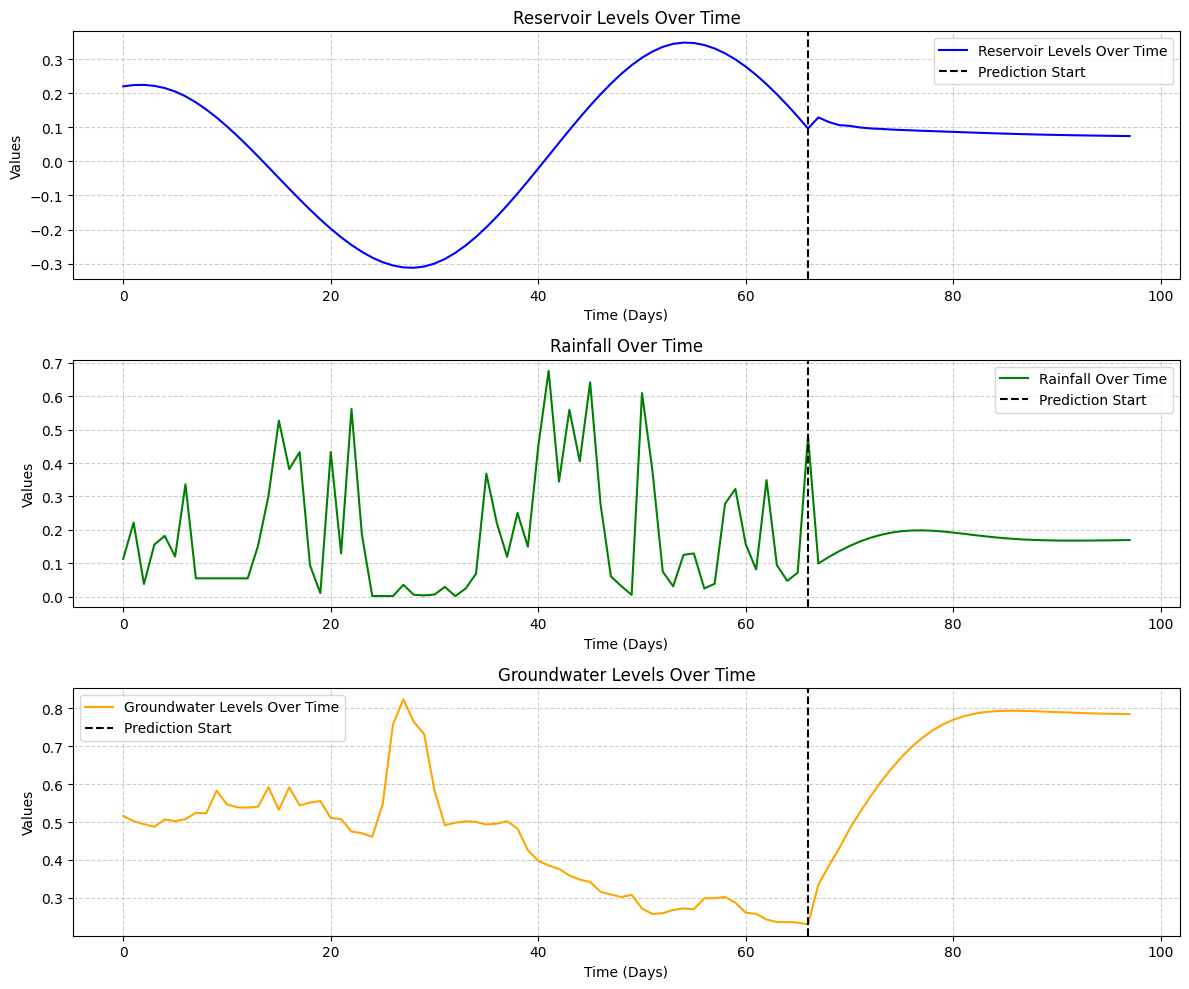

In [ ]:
plt.figure(figsize=(12, 10))
colors = ['blue', 'green', 'orange']
labels = ['Reservoir Levels', 'Rainfall', 'Groundwater Levels']

# Combine actual and future values for continuous plotting
full_days = np.arange(len(y_test) + len(future_preds))
full_values = np.concatenate((y_test, future_preds), axis=0)

for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(full_days, full_values[:, i], color=colors[i], label=f"{labels[i]} Over Time")
    plt.axvline(x=len(y_test)-1, color='black', linestyle='dashed', label="Prediction Start")  # Mark the transition
    plt.xlabel("Time (Days)")
    plt.ylabel("Values")
    plt.title(f"{labels[i]} Over Time")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 334 entries, 2023-01-01 to 2023-11-30
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Reservoir  334 non-null    float64
 1   Rainfall   334 non-null    float64
 2   GW Level   334 non-null    float64
dtypes: float64(3)
memory usage: 10.4+ KB


In [ ]:
# Combine both DataFrames
df.index = pd.to_datetime(df.index)
start_date = df.index.max() + pd.Timedelta(days=1)
future_dates = pd.date_range(start=start_date, periods=len(future_preds), freq='D')
print(future_dates)

future_preds_df = pd.DataFrame(future_preds, columns=df.columns, index=future_dates)
updated_df = pd.concat([df, future_preds_df])

DatetimeIndex(['2023-12-01', '2023-12-02', '2023-12-03', '2023-12-04',
               '2023-12-05', '2023-12-06', '2023-12-07', '2023-12-08',
               '2023-12-09', '2023-12-10', '2023-12-11', '2023-12-12',
               '2023-12-13', '2023-12-14', '2023-12-15', '2023-12-16',
               '2023-12-17', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-23', '2023-12-24',
               '2023-12-25', '2023-12-26', '2023-12-27', '2023-12-28',
               '2023-12-29', '2023-12-30', '2023-12-31'],
              dtype='datetime64[ns]', freq='D')


In [ ]:
updated_df.tail()

,Reservoir,Rainfall,GW Level
2023-12-27,0.075718,0.167795,0.786858
2023-12-28,0.075257,0.168071,0.786120
2023-12-29,0.074833,0.168428,0.785517
2023-12-30,0.074442,0.168830,0.785039
2023-12-31,0.074081,0.169253,0.784674


In [ ]:
updated_df.to_csv("/content/drive/MyDrive/Dataset/New Data/Final_Full_Year_Data.csv")

# **Further Plans**

Make a Dashboard Showcasing the Results in Stremlit! 👋